# 用决策树算法解决回归问题

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

/home/crystal/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
mydata = datasets.load_boston()
mydata.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [5]:
X = mydata.data
X.shape

(506, 13)

In [7]:
y = mydata.target
y.shape

(506,)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)


/home/crystal/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor() # 使用默认的参数，不剪枝，容易发生过拟合
dt_reg.fit(X_train, y_train)

/home/crystal/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

注意：唯一与 DecisionTreeClassifier 不同的是，DecisionTreeRegressor 中参数 criterion 的值默认为‘mse’，也可以是‘mae’

In [10]:
dt_reg.score(X_test, y_test)

0.6002239366408695

可见，预测结果不理想,我们来看一下训练数据集的得分，看是不是过拟合了呢

In [11]:
dt_reg.score(X_train, y_train)

1.0

显然数据对特定的训练数据集过拟合了

# 通过交叉验证和网格搜索寻找最优参数的方法来提高模型

1 编写 交叉验证的函数

In [12]:
def mycross_val_score(estimator, X_train, y_train):
    n = len(X_train)
    index = np.arange(n)
    np.random.shuffle(index)
    X_train1 = X_train[index[:n//3],:]
    y_train1 = y_train[index[:n//3]]
    X_train2 = X_train[index[n//3:2*n//3],:]
    y_train2 = y_train[index[n//3:2*n//3]]
    X_train3 = X_train[index[2*n//3:],:]
    y_train3 = y_train[index[2*n//3:]]
    
    score = []
    estimator.fit(np.vstack([X_train1, X_train2]), np.hstack([y_train1, y_train2]))
    score.append(estimator.score(X_train3, y_train3))
    estimator.fit(np.vstack([X_train1, X_train3]), np.hstack([y_train1, y_train3]))
    score.append(estimator.score(X_train2, y_train2))
    estimator.fit(np.vstack([X_train2, X_train3]), np.hstack([y_train2, y_train3]))
    score.append(estimator.score(X_train1, y_train1))
    return score


2 利用网格搜索的方法确定最佳的参数    
max_depth=2-10，   
max_leaf_nodes=5-20,   
min_samples_leaf=10-20,   
min_samples_split=10 -50

In [14]:
best_score, best_i,best_j, best_p, best_q = 0, 0, 0, 0, 0
for i in range(2, 10):
    for j in range(5, 20):
        for p in range(10, 20):
            for q in range(10, 50):
                bt_ref = DecisionTreeRegressor(max_depth=i, max_leaf_nodes=j, min_samples_leaf=p, min_samples_split=q)
                score = mycross_val_score(bt_ref, X_train, y_train)
                mean_score = np.mean(score)
                if mean_score > best_score: 
                    best_score, best_i,best_j, best_p, best_q = mean_score, i, j, p, q


print('best_score:',best_score)
print('max_depth:',best_i)
print('max_leaf_nodes:', best_j)
print('min_samples_leaf:', best_p)
print('min_samples_split:', best_q)

best_score: 0.803514867794803
max_depth: 7
max_leaf_nodes: 15
min_samples_leaf: 15
min_samples_split: 20


In [46]:
dt_reg1 = DecisionTreeRegressor(max_depth=7, max_leaf_nodes=15, min_samples_leaf=15, min_samples_split=20)
dt_reg1.fit(X_train, y_train)
dt_reg1.score(X_test, y_test)

0.6960421956942975

In [47]:
dt_reg1.score(X_train, y_train)

0.8514784396951789

预测结果略微有一点好转，但还不是很理想

同理也可以调用 sklearn.model_selection import GridSearchCV 来搜寻最佳参数

# 绘制学习曲线

1 编写基于mse的学习曲线

In [51]:
from sklearn.metrics import mean_squared_error
def plot_learning_curve_mse(model, X_train, X_test, y_train, y_test):
    train_score = []
    test_score = []
    for i in range(1,500):
        model.fit(X_train[:i],y_train[:i])
        y_train_predict = model.predict(X_train[:i])
        y_train_mean_squared = mean_squared_error(y_train[:i], y_train_predict)
        train_score.append(y_train_mean_squared)

        y_test_predict = model.predict(X_test)
        y_test_mean_squared = mean_squared_error(y_test, y_test_predict)
        test_score.append(y_test_mean_squared)
    plt.plot([i for i in range(1,500)], train_score, label='train_score')
    plt.plot([i for i in range(1,500)], test_score, label='test_score')
    plt.legend()
    plt.axis([0, 500, 0, 100])
    plt.show()

2 编写基于 R2 score的学习曲线

In [ ]:
from sklearn.metrics import r2_score
def plot_learning_curve_r2(model, X_train, X_test, y_train, y_test):
    train_score = []
    test_score = []
    for i in range(1,len(X_train)+1):
        model.fit(X_train[:i],y_train[:i])
        y_train_predict = model.predict(X_train[:i])
        y_train_r2_score = r2_score(y_train[:i], y_train_predict)
        train_score.append(y_train_r2_score)

        y_test_predict = model.predict(X_test)
        y_test_r2_score = r2_score(y_test, y_test_predict)
        test_score.append(y_test_r2_score)
    plt.plot([i for i in range(1,500)], train_score, label='train_score')
    plt.plot([i for i in range(1,500)], test_score, label='test_score')
    plt.legend()
    plt.axis([0, 500, 0, 1])
    plt.show()

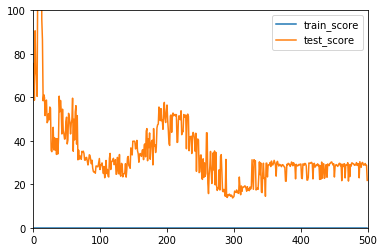

In [52]:
plot_learning_curve_mse(dt_reg, X_train, X_test, y_train, y_test)

In [ ]:
plot_learning_curve_r2(dt_reg, X_train, X_test, y_train, y_test)

从学习曲线可以看出，此模型是过拟合的

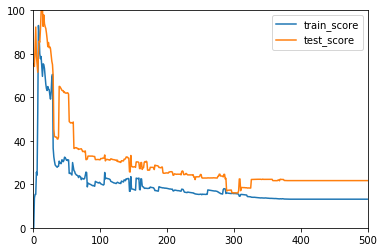

In [53]:
plot_learning_curve_mse(dt_reg1, X_train, X_test, y_train, y_test)

In [ ]:
plot_learning_curve_r2(dt_reg1, X_train, X_test, y_train, y_test)

此模型显然也是过拟合的，不过比上述的好了很多。

# 为方便增加交叉验证的组数，调用 sklearn.model_selection.GridSearchCV 来搜寻最佳参数

In [ ]:
# max_depth=2-10，
# max_leaf_nodes=5-50,
# min_samples_leaf=10-40,
# min_samples_split=10 -70,

from sklearn.model_selection import GridSearchCV
parameters = {'max_depth' : [i for i in range(2,10)],
              'max_leaf_nodes':[i for i in range(5,50)], 
              'min_samples_leaf':[i for i in range(10,40)],
             'min_samples_split':[i for i in range(10,70)]}
model = DecisionTreeRegressor()
bt_reg3 = GridSearchCV(model, parameters, cv=5, verbose=1)
bt_reg3.fit(X_train, y_train)
bt_reg3.best_estimator_


Fitting 5 folds for each of 648000 candidates, totalling 3240000 fits
